# Summary of the analyses performed - Manuscript
to be completed with further information...


In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

#
# If the background colour of the plots is the same as the VS theme, uncheck the option jupyter.themeMatplotlibPlots, 
# as indicated at https://stackoverflow.com/questions/75154449/vscode-setup-question-python-plot-background-color
# --> In macOS, go to Code -> Settings -> Settings -> Users -> jupyter:themeMatplotlibPlots
# Alternatively, for each workspace in the .vscode/setting.json file, you can add the line: 
# "jupyter.themeMatplotlibPlots": false 


## Auxiliar functions

In [29]:
def paired_plot(df, paired_points, yaxis, xaxis, ylabel, ax=None):
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.0, 6.0))
    
    df_paired = df.groupby([paired_points])

    paired_plot = df_paired.plot(x=xaxis, y=yaxis, ax=ax)
    ax.legend(paired_plot.keys().tolist(), loc='best')

    df.plot(kind='scatter', x=xaxis, y=yaxis, ax=ax, ylabel=ylabel)
    ax.set_title(yaxis)
    ax.grid(True)


In [2]:
DATAPATH = os.path.join(os.getenv('HOME'), 'Data', 'fMRIBreastData', 'analysis_2024Q4')


# DICOM data info
To get the study list in Slicer, go to the DICOM database view and copy the following into the Slicer's python console

``` python
db = slicer.dicomDatabase
patientUIDs = db.patients()

patientInfo = [','.join([db.displayedNameForPatient(patientUID), db.fieldForPatient('PatientID', patientUID), db.fieldForStudy('StudyDate', db.studiesForPatient(patientUID)[0])]) for patientUID in patientUIDs if any(db.studiesForPatient(patientUID))]

print('\n'.join(patientInfo))
```

In [19]:
# Qualitative analysis
QAdataFile = 'QualAnalysis_Tall_AQ2122023_v1'
QAdataFileExt = 'xlsx'
df_QA = pd.read_excel(os.path.join(DATAPATH, '.'.join([QAdataFile, QAdataFileExt])), sheet_name='tall')

# Replace NR (Not Reported) by NaN so the plots can proceed with no errors:
df_QA.replace('NR',np.nan, inplace=True)

# Add tumour volume MRI and Pathology Volume, both in mm3
df_QA['Tumour Volume on MRI mm3'] = df_QA['Tumour Volume on MRI'].str.split('x', expand=True).map(lambda x: int(x)).prod(axis=1)
df_QA['Pathology Volume mm3'] = df_QA['Pathology volume'].str.split('x', expand=True).map(lambda x: int(x)).prod(axis=1)
df_QA.head()


/var/folders/0v/y90qwty54psg4dqwj7dg8sl40000gn/T/ipykernel_41895/2601553365.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_QA.replace('NR',np.nan, inplace=True)


,Patient Name,Patient ID,Study Date,Treatment Timepoint,Longest diamater on MRI,Tumour Volume on MRI,% longest diamater change on MRI,% Volume remaining on MRI,ADC,FTV Total with SER=0,...,SER Washout >1.3%,Miller Payne,Pathology volume,Ki67,Tumour Cellularity%,Tumour Block,TILs,IHC,Tumour Volume on MRI mm3,Pathology Volume mm3
0,NE,ANON89073,2022-10-26,Baseline,13,13x8x11,0,0.000,0.97,445,...,5.50,0,0x0x0,0.10,0.0,0,0,"ER: positive (3+ staining, >95% of cells)\nPR:...",1144,0
1,NE,ANON89073,2022-12-15,Post-Treatment,13,13x9x11,0,1.125,1.09,1639,...,2.03,3,6x5x5,0.00,0.5,"1.5, 10% tumour cells",0,Oestrogen receptor (ER) - positive (50% with 2...,1287,150
2,EB,ANON98269,2023-06-21,Baseline,11,8x11x8,0,0.000,0.53,267,...,56.10,0,0x0x0,0.10,0.0,0,0,ER (oestrogen receptor): Positive; >95% of cel...,704,0
3,EB,ANON98269,2023-07-26,Post-Treatment,9,9x6x7,18,0.540,0.72,571,...,3.76,3,7x7x10,0.05,0.1,"1.3, <5% tumour cells",0,"ER - positive (>90%, 3+)\nPR - positive (>90%,...",378,490
4,DC,ANON97378,2023-06-21,Baseline,14,14x12x13,0,0.000,1.22,1311,...,0.42,0,0x0x0,0.10,0.0,0,0,"ER 90% 3+, PR 15% 1-2+, HER2 -ive (focally 1+),",2184,0


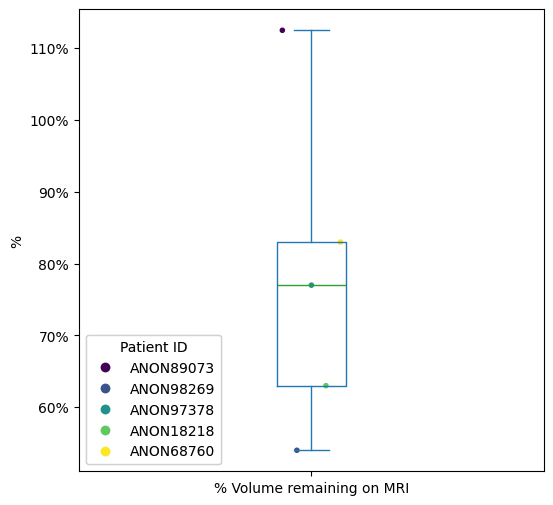

In [20]:
scatter_points = 'Patient ID'
parameter = '% Volume remaining on MRI'
sub_df = df_QA.loc[df_QA['Treatment Timepoint'] == 'Post-Treatment']
ylabel = '%'
legend_arr = sub_df[scatter_points]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.0, 6.0))

sub_df.plot(kind='box', y=parameter, label=parameter, ylabel=ylabel, ax=ax)
xpos = ax.get_xticks()
xaxes = ax.get_xlim()

# Default box width is 0.5 (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html)
boxWidth = 0.125
xsub = np.linspace(xpos - boxWidth/2, xpos + boxWidth/2, num=len(sub_df))

xs = ax.scatter(xsub, sub_df[parameter].values, marker='.', c=(xsub - xsub[0])/boxWidth)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_xlim(xaxes)

# produce a legend with the unique colors from the scatter
xs_leg = [*xs.legend_elements()]
xs_leg[1] = legend_arr.values.tolist()
legend = ax.legend(*xs_leg,
                    loc="lower left", title=scatter_points)
ax.add_artist(legend)


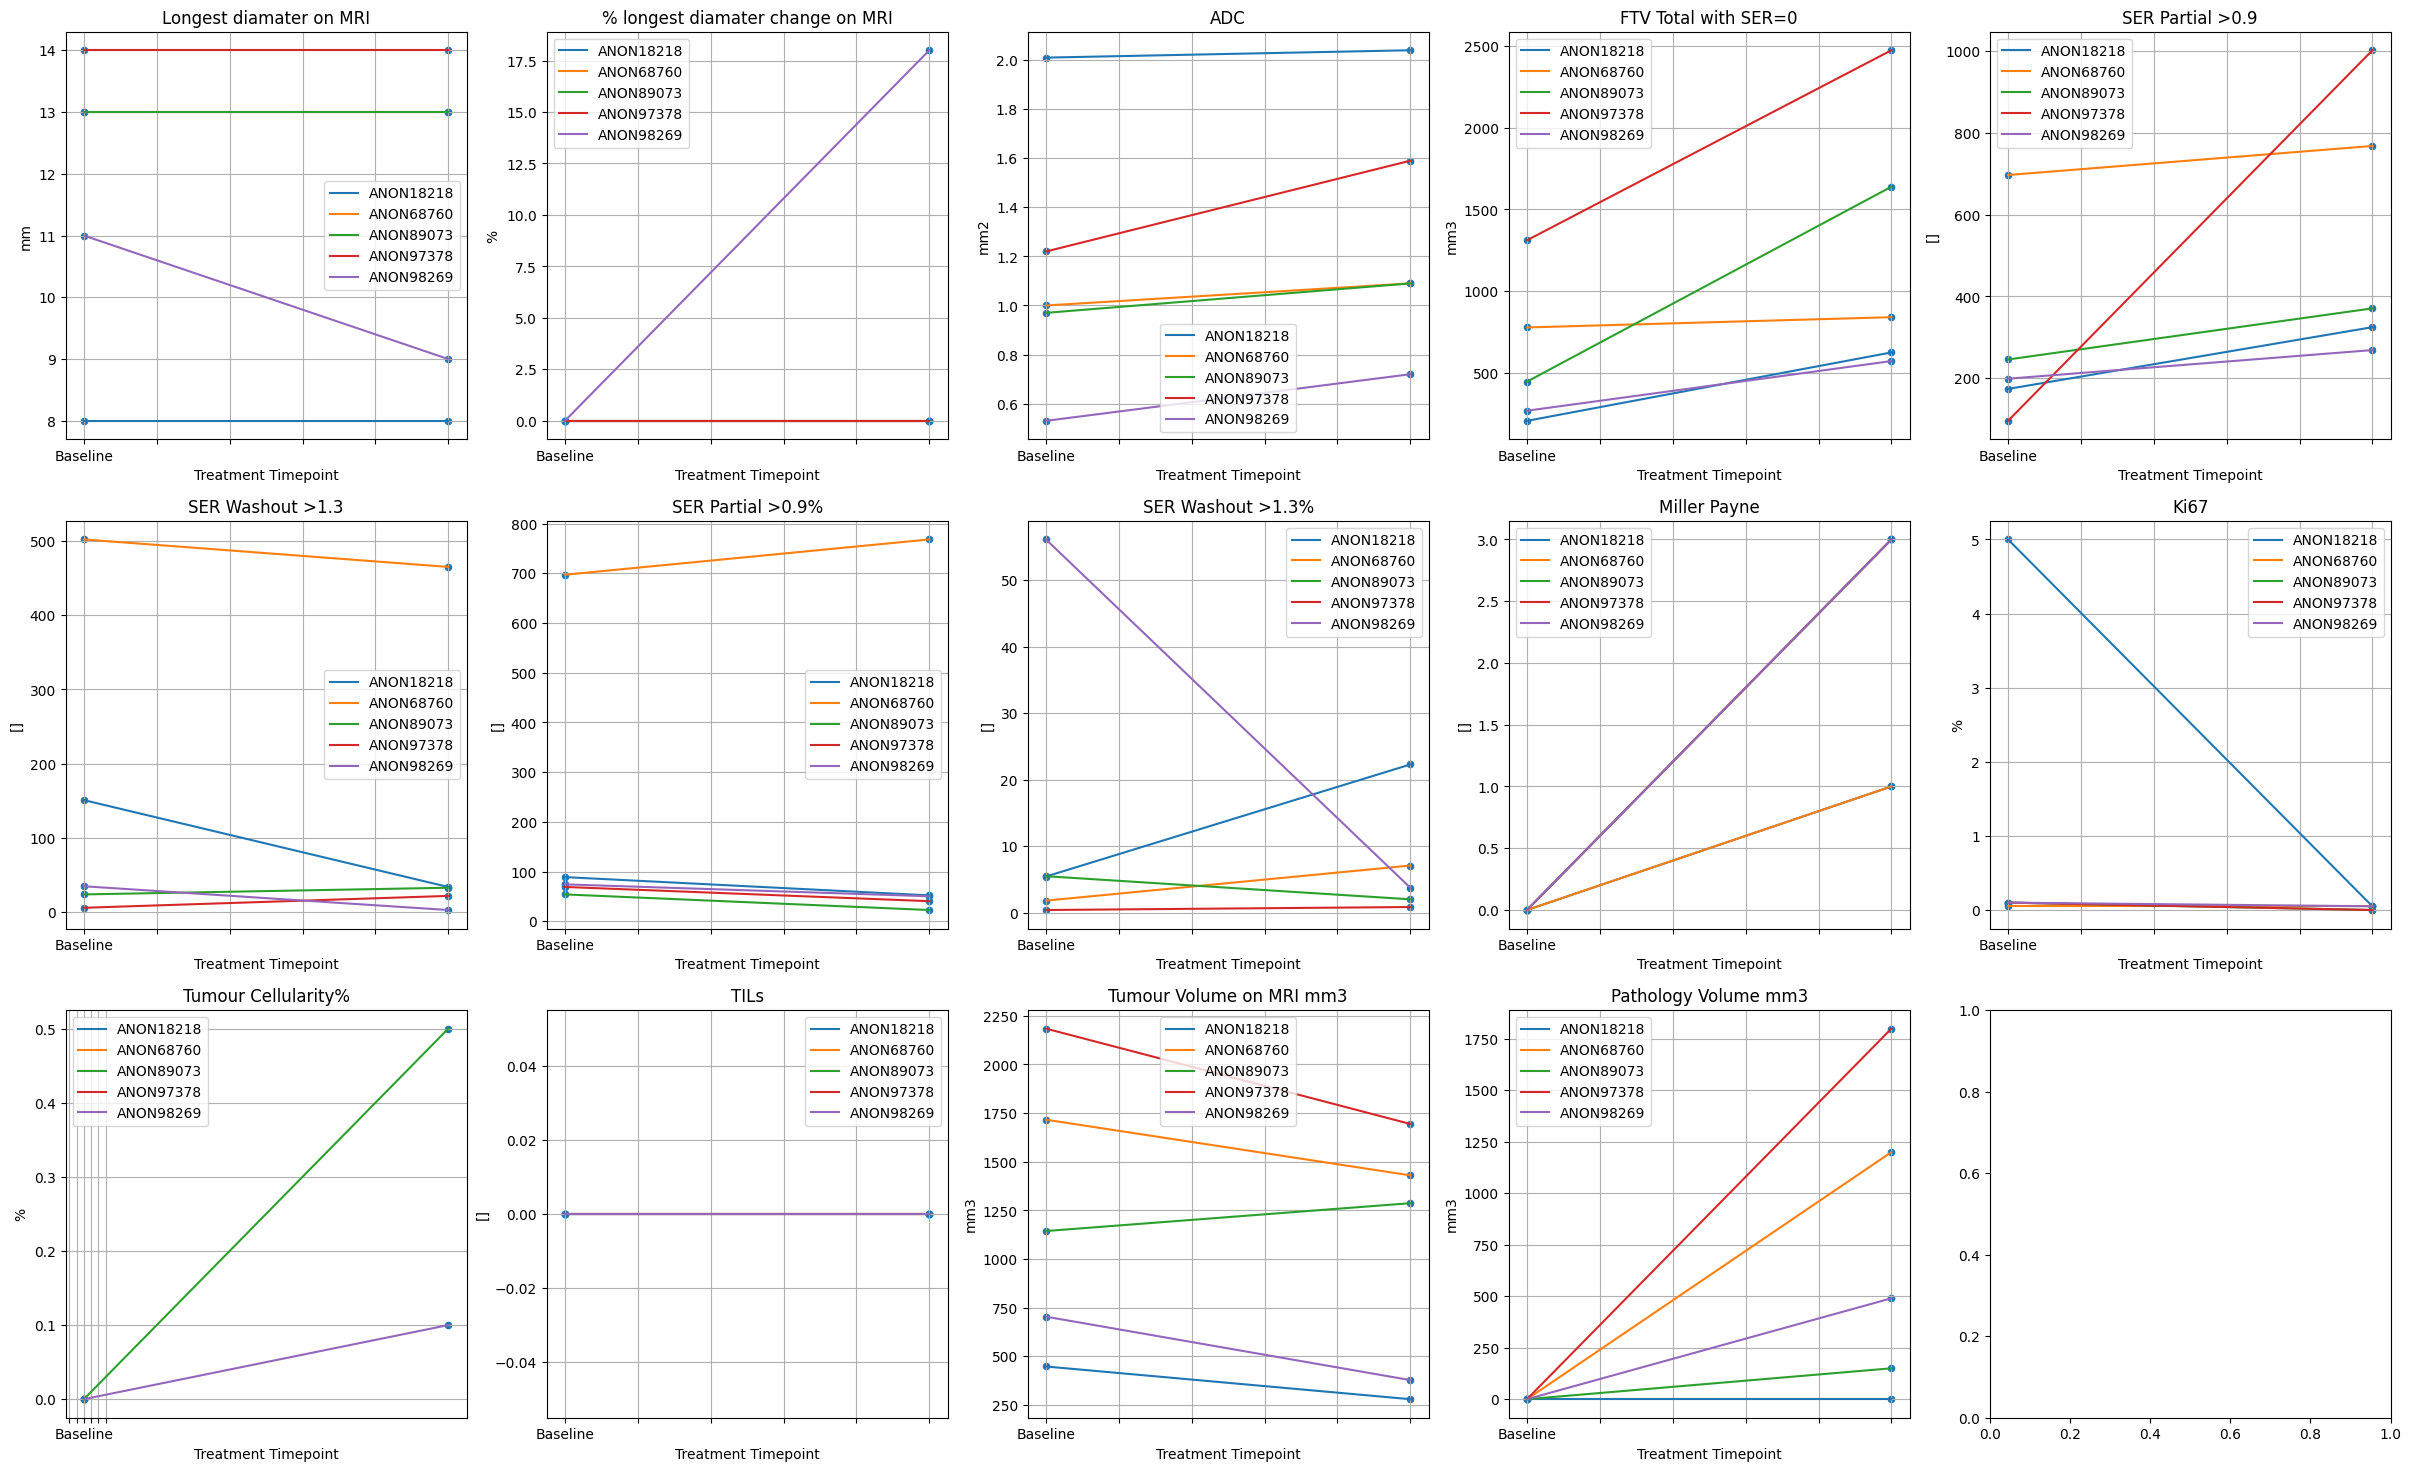

In [34]:
paired_points = 'Patient ID'
xaxis = 'Treatment Timepoint'
yaxes = {
    'Longest diamater on MRI': 'mm', 
    '% longest diamater change on MRI': '%', 
    'ADC': 'mm2', 
    'FTV Total with SER=0': 'mm3', 
    'SER Partial >0.9': '[]', 
    'SER Washout >1.3': '[]',
    'SER Partial >0.9%': '[]', 
    'SER Washout >1.3%': '[]', 
    'Miller Payne': '[]',
    'Ki67': '%', 
    'Tumour Cellularity%': '%', 
    'TILs': '[]', 
    'Tumour Volume on MRI mm3': 'mm3',
    'Pathology Volume mm3': 'mm3'
}


nfigs = len(yaxes)
nrows = int(np.floor(np.sqrt(nfigs)))
ncols = int(np.ceil(nfigs/nrows))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6.0*ncols, 6.0*nrows))
axr = ax.ravel()

for idx, (yaxis, ylabel) in enumerate(yaxes.items()):
    try:
        paired_plot(df_QA, paired_points, yaxis, xaxis, ylabel, ax=axr[idx])
    except:
        print(yaxis)
